###  importing relevant libraries

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
import sklearn
import time
import os
warnings.filterwarnings("ignore")

In [2]:
renamer={}

### Discovering Labels

In [3]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    #df["Label"]=df["Label"].replace(renamer)
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [4]:
def folder(f_name): #this function creates a folder.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("Tthe folder could not be created!")

In [5]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

In [6]:
altime=0
#def most_frequent(List): 
#    return max(set(List), key = List.count) 


 
def most_frequent(List):
    occurence_count = Counter(List)
    occurence_count={k: v for k, v in sorted(occurence_count.items(), key=lambda item: item[1],reverse=True)}
    big=list(occurence_count.values())
    big=big.count(big[0])
    return list(occurence_count.keys())[np.random.randint(big)]


def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
def create_exception(df): 
    exception_list=[]
    dominant_mac=[]
    for i in df['aggregated'].unique():
        k=df[df['aggregated']==i]
        for ii in ['MAC']:
            hist = {}
            for x in k[ii].values:
                hist[x] = hist.get(x, 0) + 1
            hist=dict(sorted(hist.items(), key=lambda item: item[1],reverse=True))
            temp=next(iter(hist))
            if temp not in dominant_mac:
                dominant_mac.append(temp)
            else:
                exception_list.append(temp)
    return exception_list




def merged(m_test,predict,step,mixed):
    second=time.time()
    mac_test=[]
    for q in m_test.index:
        mac_test.append(m_test[q])

    d_list=sorted(list(m_test.unique()))
    devices={}
    for q in d_list:
        devices[q]=[]    


    new_y=[0]*len(m_test)

    for q,qq in enumerate (mac_test):
        devices[qq].append(q)
    for q in devices:
        a = [devices[q][j:j + step] for j in range(0, len(devices[q]), step)]  
        for qq in a:
            step_list=[]
            for qqq in qq:
                step_list.append(predict[qqq])
            add=most_frequent(list(step_list))
            for qqq in qq:
                new_y[qqq]=add
    results=pd.DataFrame(m_test)
    results["aggregated"]=new_y
    results["normal"]=predict
    
    #MIXED METHOD
    if mixed:
        exception=create_exception(results)
        for q in exception:
            results.loc[results.MAC == q, 'aggregated'] = results['normal']

    return results["aggregated"].values,time.time()-second

## Calculation of evaluations

In [7]:
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ml):
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,i,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time,altime]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return line,class_based_results

In [18]:
def ML(loop1,loop2,output_csv1,cols,step,mixed,dname):

    
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        output_csv=output_csv1.replace("ML",ii)
        repetition=50
        lines=[["Dataset","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T","Al-Time"]]
        for i in tqdm(range(repetition)):



            #TRAIN
            df = pd.read_csv(loop1,usecols=cols)
            df=df.fillna(0) 
            df["Label"]=df["Label"].replace(renamer)
            m_train=df["MAC"]
            del df["MAC"]
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            #TEST
            df = pd.read_csv(loop2,usecols=cols)
            df=df.fillna(0) 
            df["Label"]=df["Label"].replace(renamer)
            df = shuffle(df, random_state=42)
            m_test=df["MAC"]
            del df["MAC"]
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes




            results_y=[]
            cv+=1
            results_y.append(y_test)


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            #print(clf.get_params())
            train_time=(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time=(float((time.time()-second)) )
            if step==1:
                altime=0
                line,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            else:
                predict,altime=merged(m_test,predict,step,mixed)
                line,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
                
                
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)
            
        class_based_results=class_based_results/(repetition)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
  
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","CB.csv"))
        if True:
            cm=cm//repetition
            graph_name=output_csv+"_confusion matrix.pdf"   
            plt.figure(figsize = (40,28))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            cm.to_csv(graph_name.replace(".pdf",".csv"))
            plt.show()
            #print(cm)
            #print("\n\n\n")             


            #plt.clf()

            
            
            
            
            



# Machine learning applications 

In [19]:
feature= ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy',
"MAC",
'Label']


In [20]:
ml_list={"DT" :DecisionTreeClassifier(criterion='entropy', max_depth=19,
                       max_features=4,min_samples_split= 2)}

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [18:21<00:00, 22.04s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_1          0     1  DT    0.988    0.901   0.911  0.901  0.895  0.987      0    1.118     0.5            0
 1  t_1          1     2  DT    0.989    0.901   0.935  0.901  0.91   0.988      0    1.129     0.503          0
 2  t_1          2     3  DT    0.989    0.901   0.935  0.901  0.91   0.988      0    1.038     0.513          0
 3  t_1          3     4  DT    0.989    0.901   0.935  0.901  0.91   0.988      0    1.055     0.54           0
 4  t_1          4     5  DT    0.988    0.9     0.911  0.9    0.895  0.987      0    0.951     0.526          0
 5  t_1          5     6  DT    0.989    0.901   0.935  0.901  0.91   0.988      0    1.034     0.464          0
 6  t_1          6     7  DT    0.988    0.901   0.911  0.901  0.896  0.987      0    1.096     

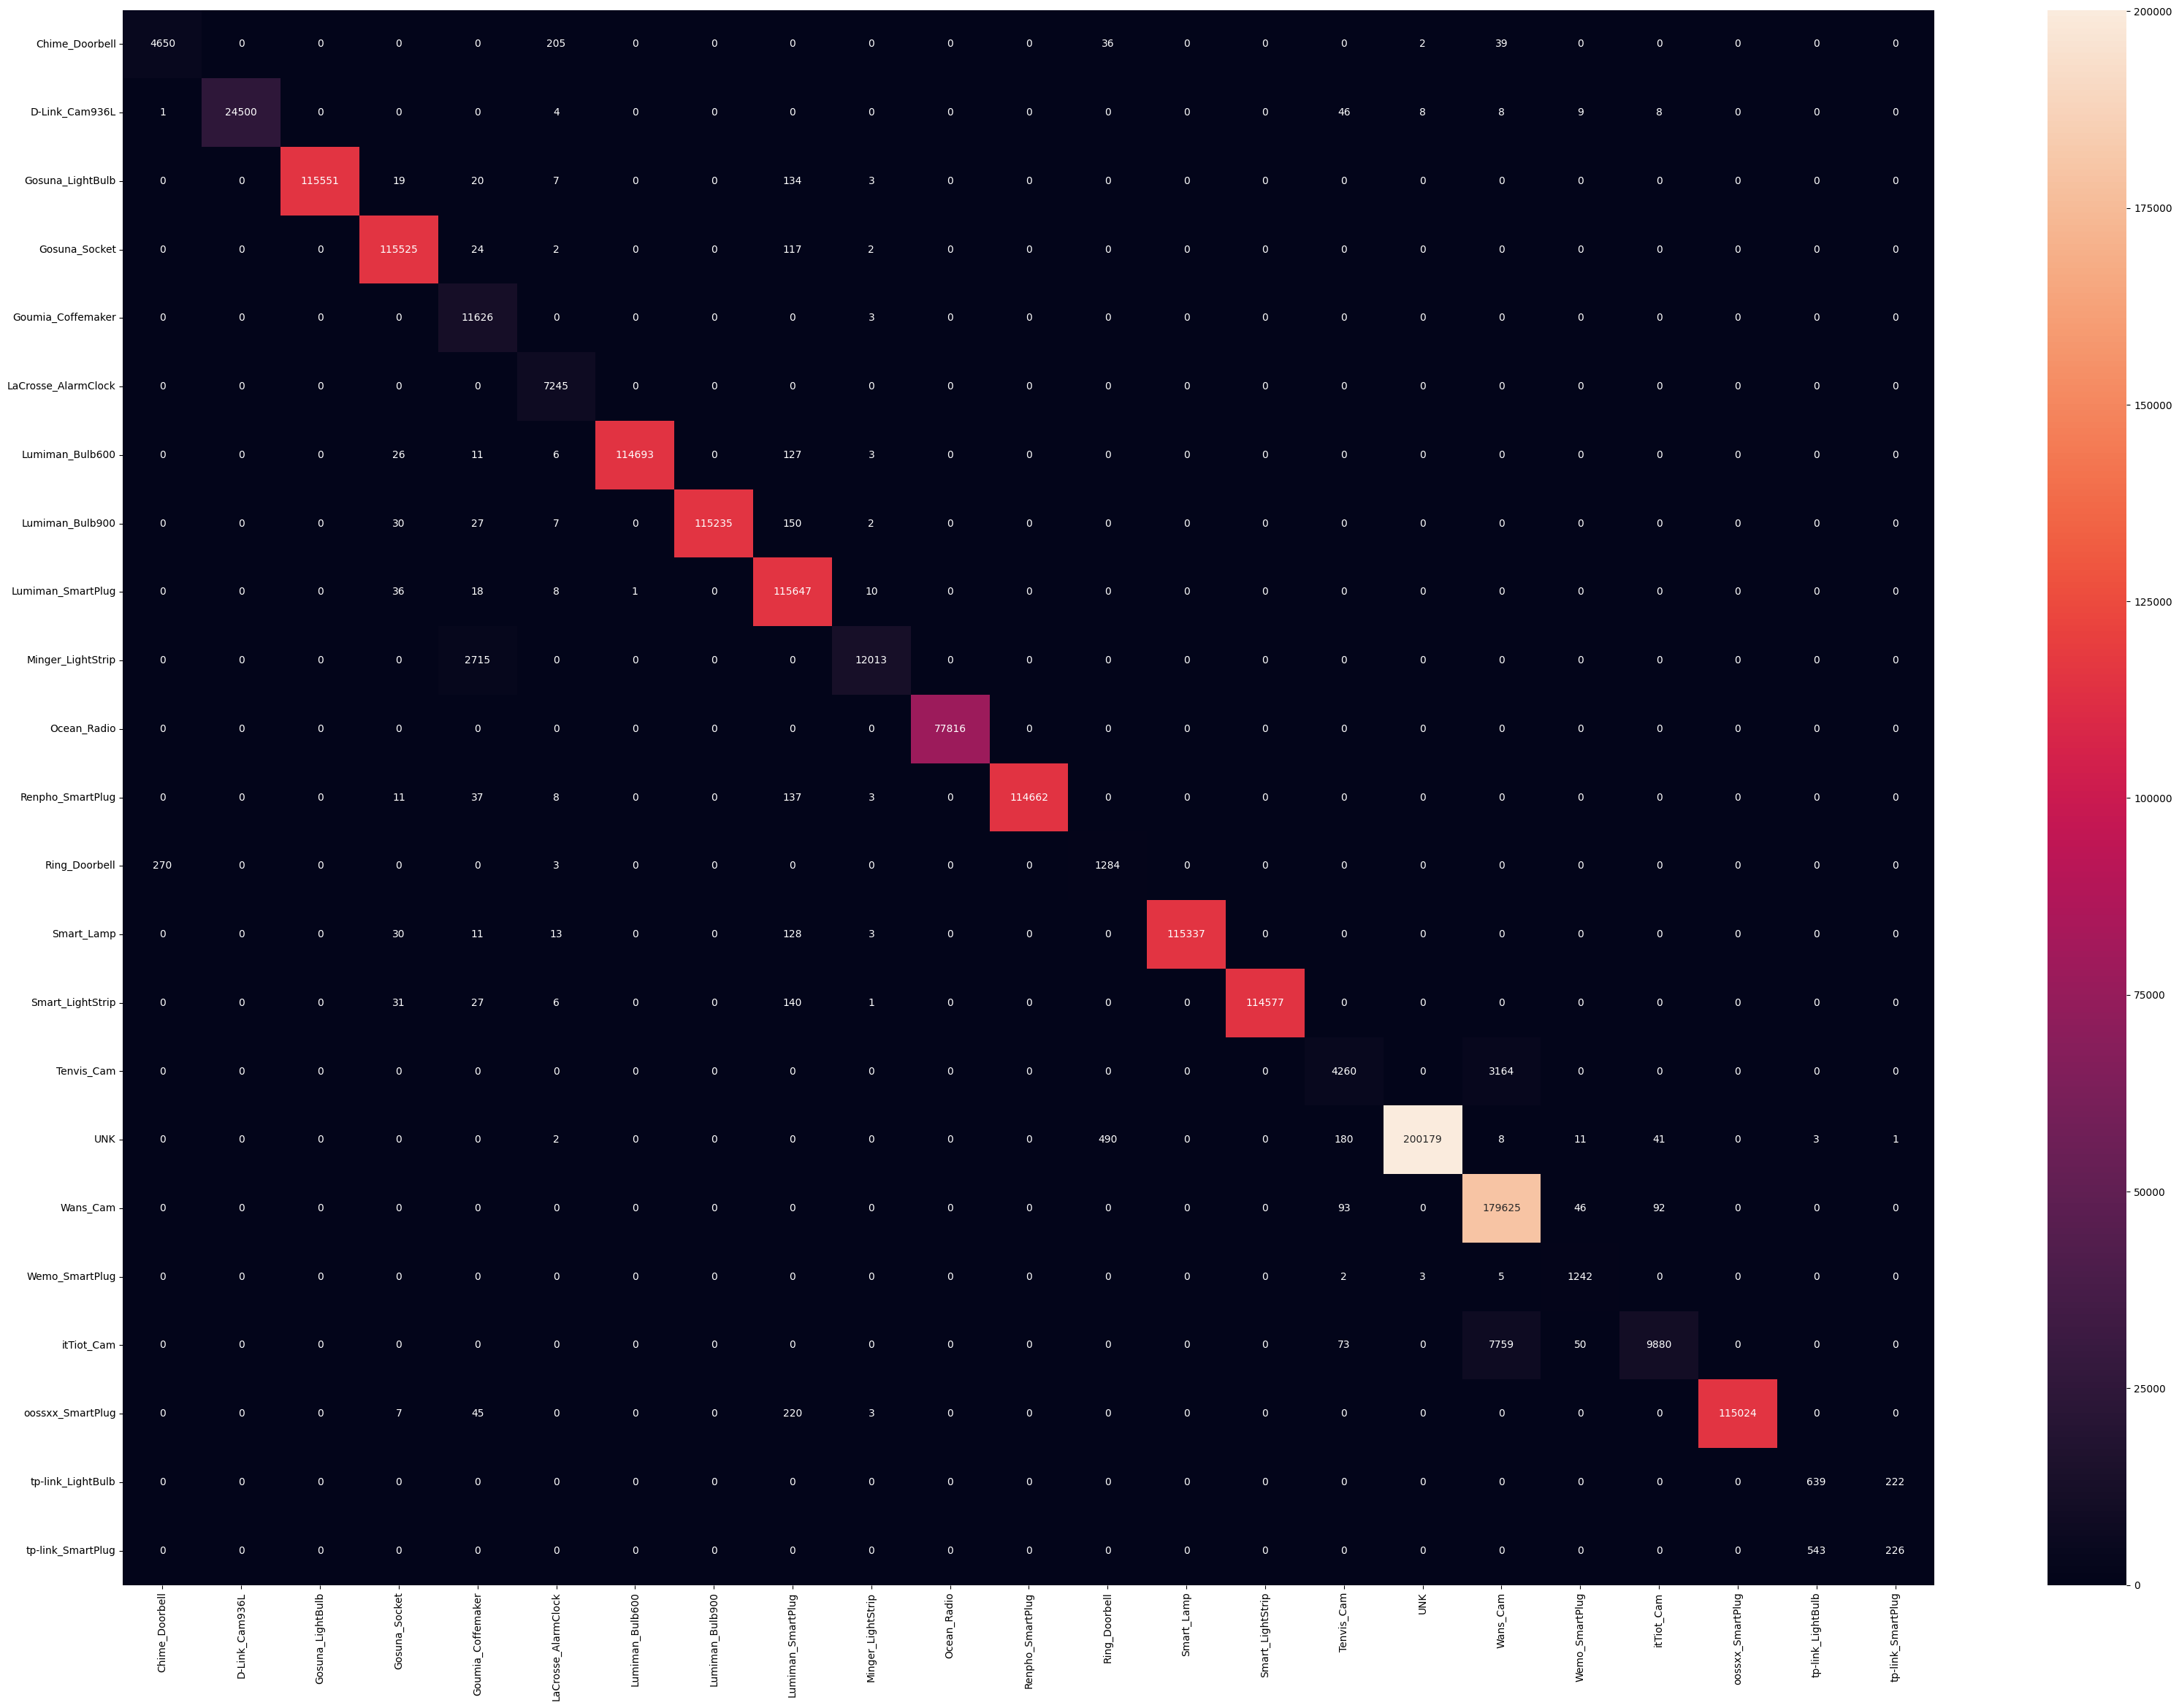

In [21]:
say=0
dataset="./results/1/"
folder(dataset)

dataset="./results/1/"
say+=1
train="Train.csv"
test="Test.csv"
mixed=False
step=1
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{step}.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [41:30<00:00, 49.82s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_13         0     1  DT    0.994    0.93    0.967  0.93   0.929  0.994      0    0.952     0.479     26.716
 1  t_13         1     2  DT    0.994    0.93    0.967  0.93   0.93   0.994      0    1.202     0.46      26.278
 2  t_13         2     3  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    1.116     0.497     25.747
 3  t_13         3     4  DT    0.994    0.93    0.967  0.93   0.929  0.994      0    0.996     0.484     26.86
 4  t_13         4     5  DT    0.994    0.93    0.967  0.93   0.93   0.994      0    1.05      0.435     26.295
 5  t_13         5     6  DT    0.994    0.93    0.967  0.93   0.93   0.994      0    1.424     0.62      31.424
 6  t_13         6     7  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    0.929     0

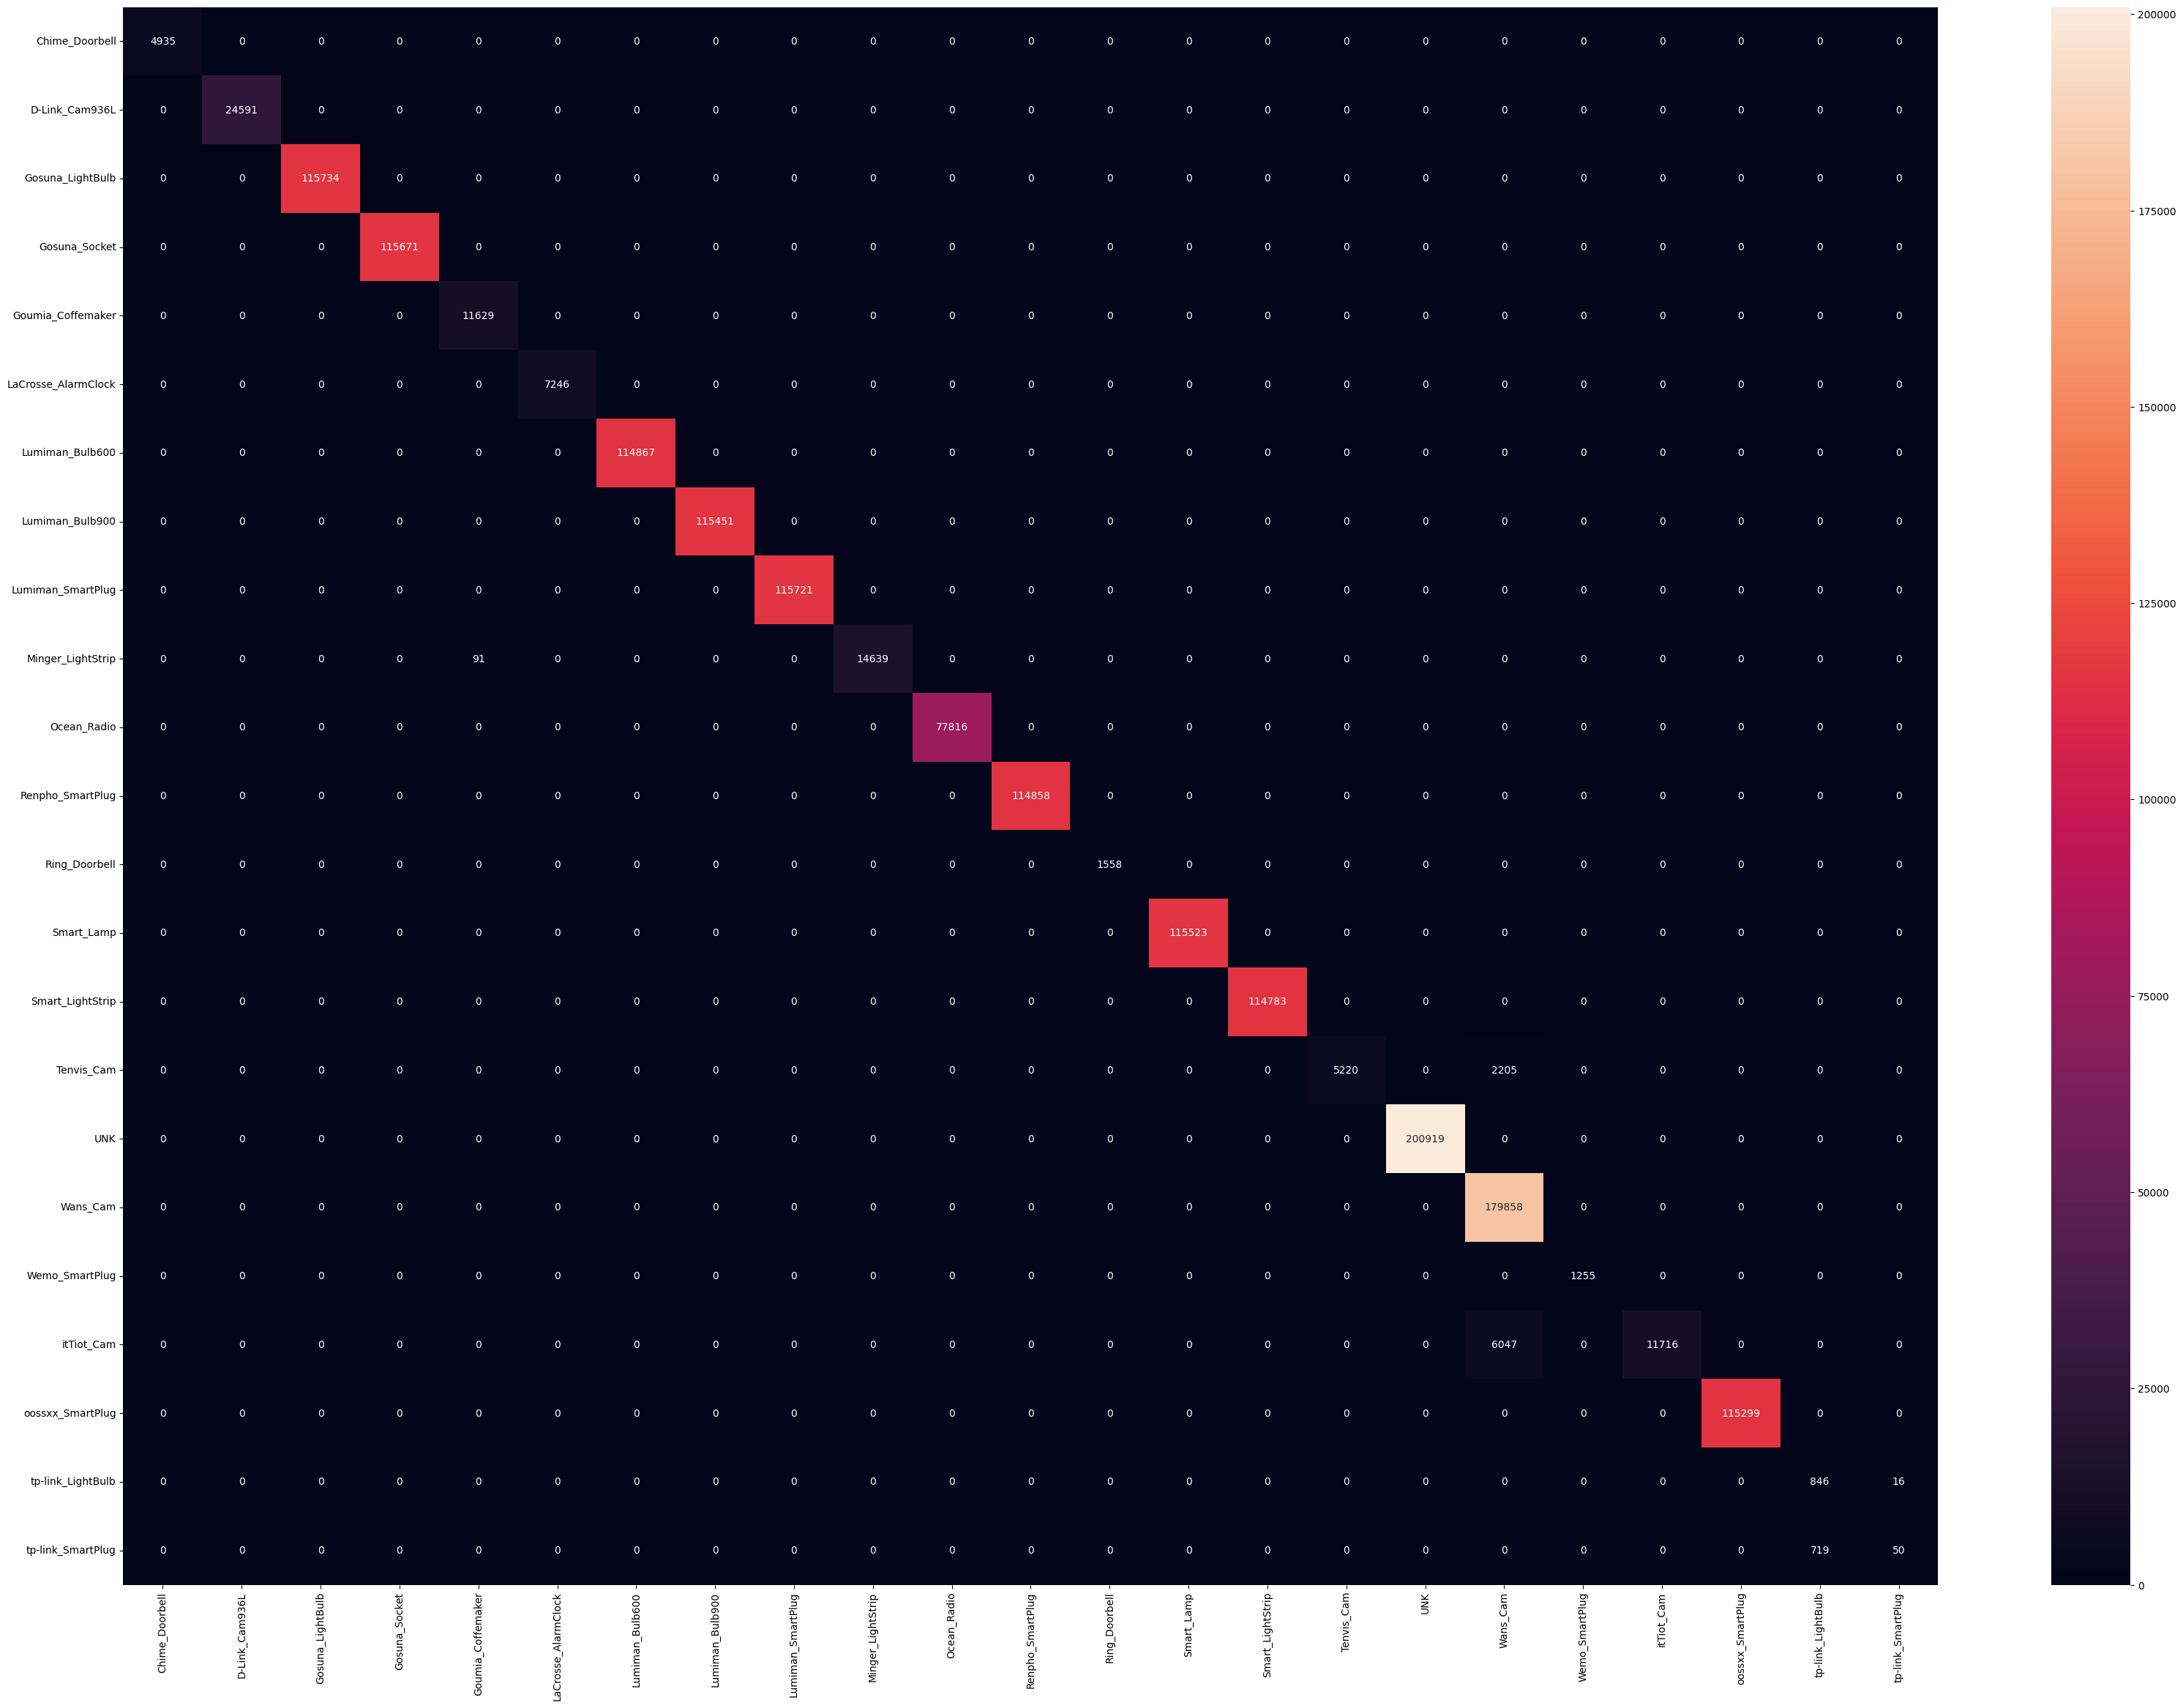

In [22]:
say=0
dataset="./results/13/"
folder(dataset)

dataset="./results/13/"
say+=1
train="Train.csv"
test="Test.csv"
mixed=False
step=13
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{step}.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 